In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
 # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X_train = np.load("256_192_train.npy")

In [3]:
y_train = np.load("train_labels.npy")

In [4]:
X_val = np.load("256_192_val.npy")

In [5]:
y_val = np.load("val_labels.npy")

In [6]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [7]:
y_train.shape, y_val.shape

((8111,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
pre_trained_model = InceptionV3(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [10]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [11]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 2048)


In [12]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)

In [13]:
# Configure and compile the model
import tensorflow.keras as keras
model.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 95, 127, 32)          0         ['batch_normalization[0][0

In [15]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [16]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

C:\Users\janar\AppData\Local\Temp\ipykernel_16980\3971016608.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/3


126/126 [==============================] - 365s 3s/step - loss: 1.9052 - accuracy: 0.6291 - val_loss: 1.3348 - val_accuracy: 0.6384
Epoch 2/3
126/126 [==============================] - 345s 3s/step - loss: 1.0132 - accuracy: 0.6735 - val_loss: 1.1606 - val_accuracy: 0.6451
Epoch 3/3
126/126 [==============================] - 353s 3s/step - loss: 0.9734 - accuracy: 0.6780 - val_loss: 0.9102 - val_accuracy: 0.6987


In [17]:
for layer in pre_trained_model.layers[249:]:
    layer.trainable = True

In [18]:

model.compile(optimizer='Adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [19]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.5, min_lr=0.00001,cooldown=2)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 95, 127, 32)          0         ['batch_normalization[0][0

In [21]:
batch_size = 64
epochs = 35
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

C:\Users\janar\AppData\Local\Temp\ipykernel_16980\1245916579.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/35
126/126 [==============================] - 360s 3s/step - loss: 0.9268 - accuracy: 0.6860 - val_loss: 2.4377 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 2/35
126/126 [==============================] - 368s 3s/step - loss: 0.7756 - accuracy: 0.7319 - val_loss: 0.8983 - val_accuracy: 0.7054 - lr: 0.0010
Epoch 3/35
126/126 [==============================] - 378s 3s/step - loss: 0.7088 - accuracy: 0.7497 - val_loss: 0.7123 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 4/35
126/126 [==============================] - 365s 3s/step - loss: 0.6639 - accuracy: 0.7615 - val_loss: 0.6970 - val_accuracy: 0.7723 - lr: 0.0010
Epoch 5/35
126/126 [==============================] - 371s 3s/step - loss: 0.6155 - accuracy: 0.7838 - val_loss: 0.7801 - val_accuracy: 0.7121 - lr: 0.0010
Epoch 6/35
126/126 [==============================] - 369s 3s/step - loss: 0.5856 - accuracy: 0.7967 - val_loss: 0.7757 - val_accuracy: 0.8080 - lr: 0.0010
Epoch 7/35
126/126 [==============================] - 366s 3s/st

In [22]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 13s 449ms/step - loss: 0.7490 - accuracy: 0.8115
Validation: accuracy = 0.811530  ;  loss_v = 0.748998


In [23]:
X_test = np.load("256_192_test.npy")

In [24]:
y_test = np.load("test_labels.npy")
y_test = to_categorical(y_test)

In [25]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 16s 500ms/step - loss: 0.8173 - accuracy: 0.8234
Test: accuracy = 0.823353  ;  loss = 0.817291


In [27]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

29/29 [==============================] - 15s 452ms/step
Classification report for classifier <keras.src.engine.functional.Functional object at 0x0000016FA4E90450>:
              precision    recall  f1-score   support

     class 0       0.81      0.52      0.63        33
     class 1       0.85      0.67      0.75        51
     class 2       0.57      0.67      0.61        96
     class 3       0.75      0.67      0.71         9
     class 4       0.88      0.93      0.90       600
     class 5       1.00      0.79      0.88        14
     class 6       0.56      0.40      0.47        99

    accuracy                           0.81       902
   macro avg       0.77      0.66      0.71       902
weighted avg       0.81      0.81      0.80       902




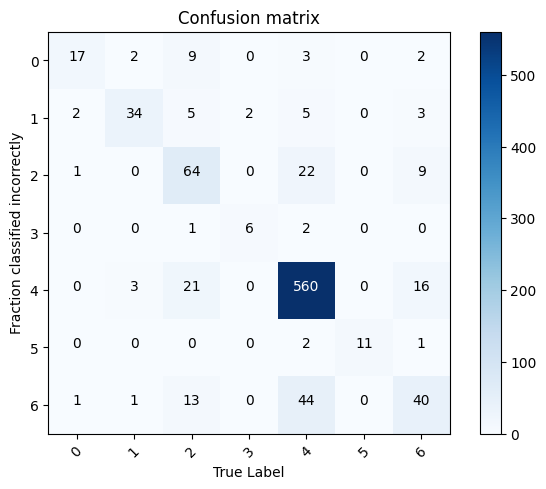

In [28]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

      #classes = {
 #0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
 #1: ('bcc', 'basal cell carcinoma'),
 #2: ('bkl', 'benign keratosis-like lesions'),
 #3: ('df', 'dermatofibroma'),
 #4: ('nv', 'melanocytic nevi'),
 #5: ('vasc', 'pyogenic granulomas and hemorrhage'),
 #6: ('mel', 'melanoma')}

In [29]:
model.save("InceptionV3FT.h5")

C:\Users\janar\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Training and validation loss')

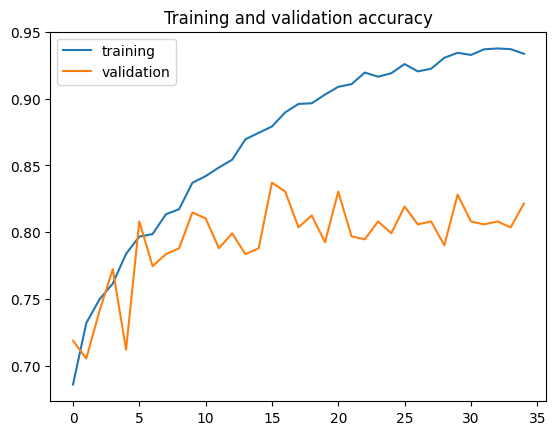

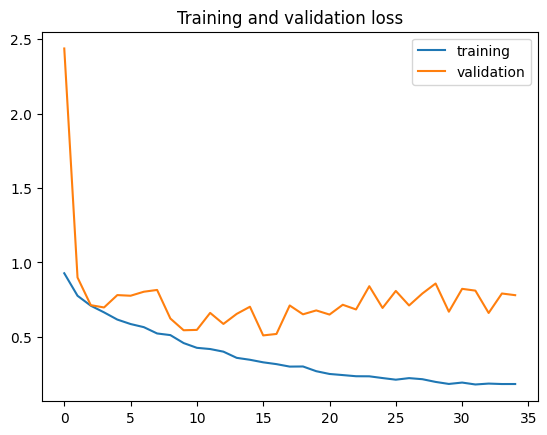

In [30]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')